# Correlation Analysis

各細胞の発火時系列が与えられたとき，2細胞の発火の時間的相関（temporal correlation）から，ネットワークの構造を推定することができる．

本ノートブックでは，文献 {cite}`Kobayashi2019`で結合推定のデモデータとして使用されていた，ラットの行動タスク遂行時の海馬の活動データを用いる．元のデータの論文，データ詳細についてはCRCNSのホームページに記載されている．  
http://crcns.org/data-sets/hc/hc-3/about-hc-3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 140

In [67]:
datadir = '../datasets/02/'
df = pd.read_csv(datadir + 'spikes_unit.csv', index_col=0)

display(df.head())

,unit,spiketime
0,0,-99618.990000
1,0,-96536.180002
2,0,-95920.130002
3,0,-93842.150003
4,0,-92885.660004


In [5]:
# filename = '../datasets/02/all.txt'
# spiketime = {}

# with open(filename) as f:
#     neuron_id = 0
#     spiketime[neuron_id] = []
    
#     for line in f:
#         value = line.rstrip()
        
#         if value == ';':
#             neuron_id += 1
#             spiketime[neuron_id] = []
#         else:
#             spiketime[neuron_id].append(value)
            
# lst_neurons = []
# lst_spiketime = []

# for key, value in spiketime.items():
#     lst_neurons.extend([key] * len(value))
#     lst_spiketime.extend(value)
    
# df = pd.DataFrame({'unit': lst_neurons, 'spiketime': lst_spiketime})
# df.to_csv('../datasets/02/spikes_unit.csv')

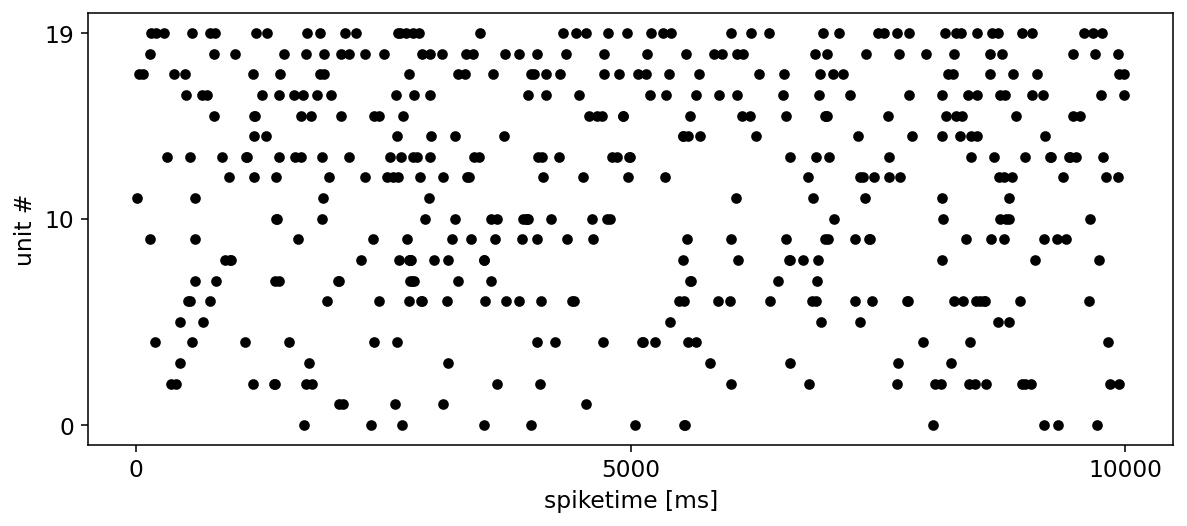

In [69]:
start, end = 0.0, 10000.0

fig, ax = plt.subplots(figsize=(10, 4))
df.query('@start <= spiketime <= @end').plot.scatter(x='spiketime', y='unit', c='k', ax=ax)
ax.set_xlabel('spiketime [ms]')
ax.set_ylabel('unit #')
ax.set_yticks([0, 10, 19])

plt.locator_params(axis='x', nbins=4)
plt.show()

## Cross-Correlation

相互相関ヒストグラムを取る手順は次のようになる．

1. 相互相関ヒストグラムの窓幅（50ms）を決める．
2. 二つのspike train（reference unit: $j$, target unit: $i$）における各spikeについて，窓幅以内の時間差で発生した2つのspikeについて，相対発火時刻（target - reference）を列に格納する．
3. 相対発火時刻の列について，特定のbin幅（1ms）によりヒストグラムを作成する．

```{tip}
相対発火時刻を計算する際，spike trainが昇順で並んでいることを前提に探索を行うのが効率的である．
```

In [106]:
def spiketime_relative(spike_times_i, spike_times_j, window_size=50.0):
    t_sp = []
    i_min, i_max = 0, 0

    for t_j in spike_times_j:
        # reuse search index for next iteration to decrease the amount of elements to scan
        i_min = _upper_bound_idx(lst=spike_times_i, upper=t_j - window_size, start_idx=i_min)
        i_max = _upper_bound_idx(lst=spike_times_i, upper=t_j + window_size, start_idx=i_max)
        t_sp.extend([(spike_times_i[i] - t_j) for i in range(i_min, i_max)])
        
    return t_sp

def _upper_bound_idx(lst, upper, start_idx=0):
    idx = start_idx
    while idx < len(lst) and lst[idx] <= upper:
        idx += 1
    return idx

def cross_correlogram(spike_times_i, spike_times_j, window=50., nbins=101):
    t_sp = spiketime_relative(spike_times_i, spike_times_j)
    hist, edges = np.histogram(t_sp, bins=np.linspace(-window, window, nbins))
    return hist, edges

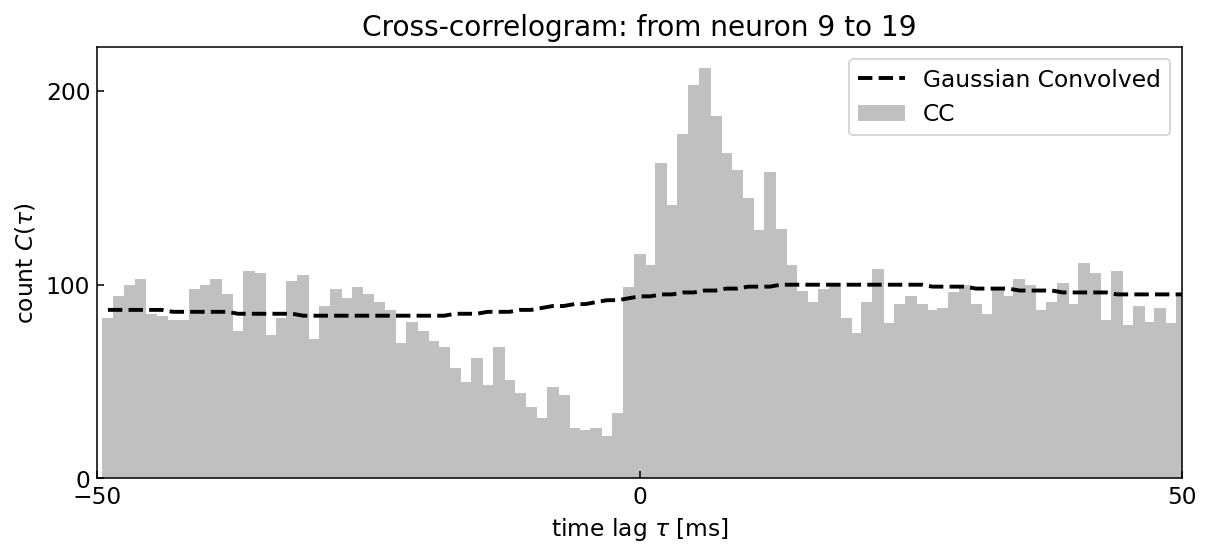

In [142]:
i, j = 19, 9
spike_times_i = df.query(f'unit=={i}').spiketime.values
spike_times_j = df.query(f'unit=={j}').spiketime.values

hist, edges = cross_correlogram(spike_times_i, spike_times_j)
hist_g = gaussian_filter(hist, sigma=[20])

plt.figure(figsize=(10, 4))
plt.title(f'Cross-correlogram: from neuron {j} to {i}')
plt.bar(edges[1:], hist, color='#C0C0C0', width=1.1, label='CC')
plt.plot(edges[1:], hist_g, color='k', linewidth=2.0, linestyle='dashed', label='Gaussian Convolved')

plt.legend()
plt.xlabel(r'time lag $\tau$ [ms]')
plt.ylabel(r'count $C(\tau)$')
plt.xlim(-50, 50)
plt.xticks([-50, 0, 50])
plt.yticks([0, 100, 200])
plt.tick_params(direction='in')
plt.show()

上に示した相互相関ヒストグラムの見方は次の通りである．横軸$\tau$は，**reference neuronのspike時刻を基準とした相対発火時刻**を表す．  
neuron 9の発火はneuron 19の発火を促進する傾向（$\tau > 0$）があり，一方でneuron 19の発火はneuron 9の発火を抑制する傾向（$\tau < 0$）がある．

## Effective Connectivity

シナプス結合は，以下の3種類に大別することができる {cite}`sporns2004organization`．

```{important}
1. **構造的結合（structural connectivity）/ 解剖学的結合（anatomical connectivity）**:  
    ニューロン間のシナプスを形成する軸索や樹状突起など、脳領域間の物理的結合を指す。
2. **機能的結合（functional connectivity）**:  
    領域間の統計的な依存関係や相関関係を指す．機能的結合は必ずしも解剖学的な直接的結合とは対応せず、異なる脳領域が機能的に結合または同期している度合いを反映する。
3. **実効的結合（effective connectivity）**:  
    ある脳領域が他の脳領域に与える因果的な影響のことで、脳内ネットワークにおける情報の流れの方向と強さに関する情報を提供する。
```

相互相関ヒストグラムにより推定される結合強度は，実効的結合である．実効的結合は，必ずしも神経伝達物質の放出量や受容体の密度といったシナプスの生理学的特性と対応するとは限らないが，発火活動における因果的な影響の指標として有効である．

ここで，**$W_{ij}$をneuron $j$からneuron $i$への実効的結合強度とする**．相互相関ヒストグラムは，以下の3要素に分解できる{cite}`Spivak2022`．
1. 多数の神経細胞から流入するbackground活動（baseline）
2. neuron $j$からneuron $i$への因果的影響力（$\tau > 0$）
3. neuron $i$からneuron $j$への因果的影響力（$\tau < 0$）

1は，相互相関ヒストグラムを平滑化した曲線により近似することができ，簡易的にはガウシアンカーネルによる畳み込みがよく用いられる．  
2, 3については，シナプス伝達遅れが一般に $\tau=1 \sim 5 $ msであることを踏まえ，簡易的には該当範囲でCCを加算した結果を正規化した値を用いたり，シナプス効果のモデル（e.g. アルファ関数）をフィッティングした係数が用いられたりする．

以下では，{cite}`English2017`を元にした実装を述べる．シナプス効果を忠実にモデル化した例としては{cite}`Kobayashi2019`などがある．

In [92]:
import itertools
import seaborn as sns

シナプス効果が反映されたCCの領域として，以下の領域を採用する．

In [143]:
print('range of synaptic delay: ')
print(edges[1:][44:48])
print(edges[1:][51:55])

range of synaptic delay: 
[-5. -4. -3. -2.]
[2. 3. 4. 5.]


---

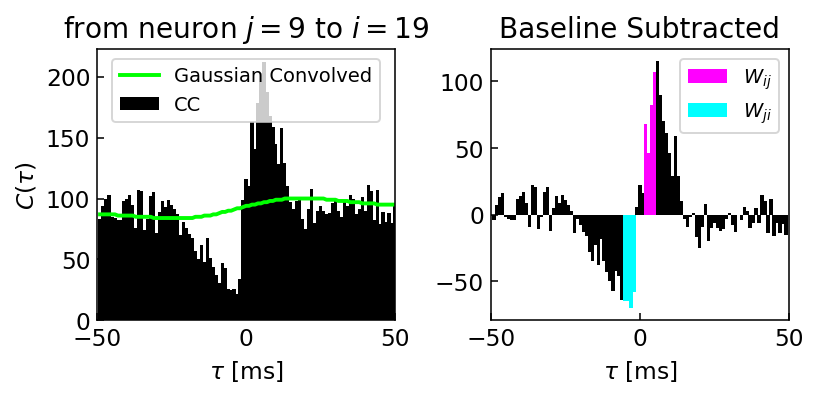

In [144]:
i, j = 19, 9
spike_times_i = df.query(f'unit=={i}').spiketime.values
spike_times_j = df.query(f'unit=={j}').spiketime.values

hist, edges = cross_correlogram(spike_times_i, spike_times_j)
hist_g = gaussian_filter(hist, sigma=[20])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.set_title(rf'from neuron $j={j}$ to $i={i}$')
ax1.bar(edges[1:], hist, color='k', width=1.1, label='CC')
ax1.plot(edges[1:], hist_g, color='lime', linewidth=2.0, label='Gaussian Convolved')
ax1.legend(fontsize=10, loc='upper center')

ax1.set_xlabel(r'$\tau$ [ms]')
ax1.set_ylabel(r'$C(\tau)$')
ax1.set_xlim(-50, 50)
ax1.set_xticks([-50, 0, 50])
ax1.tick_params(direction='in')

hist_sub = hist - hist_g
ax2.set_title('Baseline Subtracted')
ax2.bar(edges[1:], hist_sub, color='k', width=1.1)

ax2.bar(edges[1:][51:55], hist_sub[51:55], color='magenta', width=1.1, label=r'$W_{ij}$')
ax2.bar(edges[1:][44:48], hist_sub[44:48], color='cyan', width=1.1, label=r'$W_{ji}$')
ax2.legend(fontsize=10, loc='upper right')

ax2.set_xlabel(r'$\tau$ [ms]')
ax2.set_xlim(-50, 50)
ax2.set_xticks([-50, 0, 50])
ax2.tick_params(direction='in')

plt.tight_layout()
plt.show()

左図が2ニューロン間で作成された相互相関ヒストグラムとガウスカーネルにより平滑化された曲線，右側が相互相関ヒストグラムから平滑化されたベースラインの曲線を差し引いたヒストグラムである．シナプス効果が反映されていると考えられる領域を，マゼンタ・シアンで示した．この領域の合計を，シナプスの実効的結合強度とみなす．ただし，合計値はpresynaptic neuron（reference neuron）のspike数で割ることにより正規化する．

In [124]:
def estimate_connectivity(spike_times_i, spike_times_j, start=2, end=5, window=50., nbins=101):
    # CC - CCG
    hist, edges = cross_correlogram(spike_times_i, spike_times_j, window, nbins)
    hist_g = gaussian_filter(hist, sigma=[20])
    hist_sub = hist - hist_g

    # range of synaptic delay
    edges_ = edges[1:]
    idx_ij = (start <= edges_) & (edges_ <= end)  # j --> i
    idx_ji = (-end <= edges_) & (edges_ <= -start)  # i --> j
    w_ij = np.sum(hist_sub[idx_ij]) / len(spike_times_j)  # normalize the sum with the number of presynaptic spikes
    w_ji = np.sum(hist_sub[idx_ji]) / len(spike_times_i)
    return w_ij, w_ji

In [125]:
neurons = set(df.unit)
n_neurons = len(neurons)
w = np.zeros((n_neurons, n_neurons))

for (i, j) in itertools.combinations(neurons, 2):
    if i == j:
        continue
    else:
        spike_times_i = df.query(f'unit=={i}').spiketime.values
        spike_times_j = df.query(f'unit=={j}').spiketime.values
        w_ij, w_ji = estimate_connectivity(spike_times_i, spike_times_j)
        w[i, j] = w_ij
        w[j, i] = w_ji

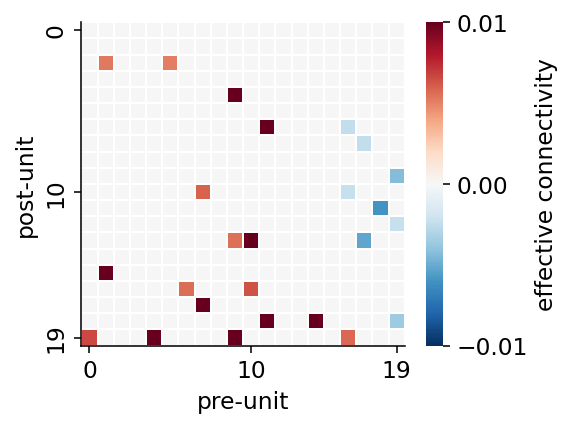

In [131]:
fig, ax = plt.subplots(figsize=(4, 3))

# thresholding weight matrix
w_ = np.zeros_like(w)

thre_exc = 0.005
thre_inh = 0.002
w_[w > thre_exc] = w[w > thre_exc]
w_[w < -thre_inh] = w[w < -thre_inh]

# plotting
sns.heatmap(w_, vmax=0.01, vmin=-0.01, center=0, ax=ax, cmap=plt.get_cmap('RdBu_r'), 
            linewidths=1.0, cbar_kws=dict(ticks=[0.01, 0, -0.01], label='effective connectivity'))

ax.set_xticks([0.5, 10.5, 19.5])
ax.set_yticks([0.5, 10.5, 19.5])
ax.set_xticklabels([0, 10, 19])
ax.set_yticklabels([0, 10, 19])
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

ax.set_xlabel('pre-unit')
ax.set_ylabel('post-unit')
ax.set_aspect('equal')
plt.show()

```{tip}
推定されたシナプス強度は，同じpre-unit（シナプス前細胞）について，興奮性あるいは抑制性の分類が一貫しているか確かめると良い．上の例では，列方向（縦）．例えば，neuron 17, 18, 19は抑制性細胞である可能性が高い．
```

## Visualizing Connectivity Network

推定された実効的結合強度に基づき，神経ネットワークをnetworkxにより可視化するコードの一例を以下に示す．

In [132]:
import networkx as nx

In [136]:
G = nx.DiGraph()

for neuron in neurons:
    G.add_node(neuron)

for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        w_ij = w[i, j]
        if w_ij > thre_exc:
            G.add_edge(j, i, weight=w_ij, color='magenta')  # exc
        elif w_ij < -thre_inh:
            G.add_edge(j, i, weight=w_ij, color='cyan')  # inh

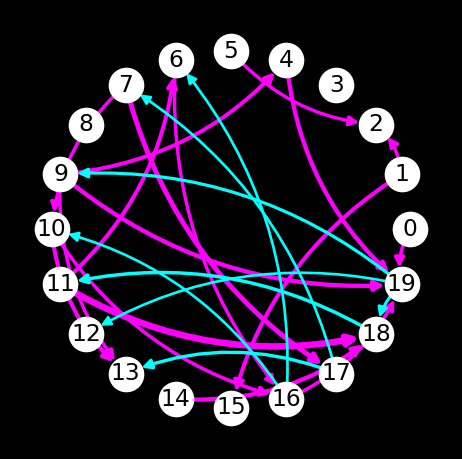

In [137]:
edge_color = [G[u][v]['color'] for u, v in G.edges()]
edge_width = [np.log10(abs(G[u][v]['weight'])) + 4 for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(4, 4))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_color='w', font_color='k', 
        edge_color=edge_color, width=edge_width, arrows=True, arrowsize=10, connectionstyle='arc3, rad=0.2')

fig.set_facecolor('k')
plt.show()

ネットワークはBokehを使えばインタラクティブに可視化することもできる．

In [138]:
from bokeh.io import show, output_notebook
from bokeh.plotting import curdoc, figure, from_networkx
from bokeh.models import Circle, MultiLine, NodesAndLinkedEdges
from bokeh.palettes import Spectral8
output_notebook()

Loading BokehJS ...

In [139]:
def make_network_plot(G, pos):
    node_highlight_color = Spectral8[4]
    edge_highlight_color = Spectral8[4]
    
    HOVER_TOOLTIPS = [("neuron", "@index"), ("degree", "@degree")]
    plot = figure(tooltips = HOVER_TOOLTIPS, tools="pan,box_zoom,wheel_zoom,save,reset", width=400, height=400)
    
    plot.axis.major_tick_line_color = None
    plot.axis.minor_tick_line_color = None
    plot.axis.major_label_text_color = None  
    plot.xgrid.visible = False
    plot.ygrid.visible = False  
    
    network_graph = from_networkx(G, pos, scale=8, center=(0, 0))
    network_graph.node_renderer.glyph = Circle(size=20, fill_color='white')
    network_graph.node_renderer.hover_glyph = Circle(size=20, fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size=20, fill_color=node_highlight_color, line_width=2)

    network_graph.edge_renderer.glyph = MultiLine(line_color='edge_color', line_alpha=0.8, line_width='edge_width')
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='edge_width')
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='edge_width')
    
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()
    plot.renderers.append(network_graph)
    return plot

In [140]:
# node attributes
nx.set_node_attributes(G, name='degree', values=dict(nx.degree(G)))

# edge attributes
edge_color = {(u, v): G[u][v]['color'] for u, v in G.edges()}
edge_width = {(u, v): np.log10(abs(G[u][v]['weight'])) + 8 for u, v in G.edges()}

nx.set_edge_attributes(G, edge_color, "edge_color")
nx.set_edge_attributes(G, edge_width, "edge_width")

curdoc().theme = 'dark_minimal'
p = make_network_plot(G, nx.circular_layout(G))
show(p)

---
```{bibliography}
:filter: docname in docnames
```